#   DS-INTERN-TESLA STOCK PRICE PREDICTION
    
### Y SANTHI SWARUP
   
     ysswarup18@gmail.com
   
#### Datasets used
-  Nasdaq:  https://www.nasdaq.com/
-  Xignite: https://www.xignite.com/

   

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [2]:
df = pd.read_csv('HistoricalData_TSLA.csv',parse_dates = ["Date"], index_col = "Date")
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-09,$598.78,16584570,$602.17,$611.79,$597.6301
2021-06-08,$603.59,26053410,$623.01,$623.09,$595.5
2021-06-07,$605.13,22543680,$591.825,$610,$582.88
2021-06-04,$599.05,24036900,$579.71,$600.61,$577.2
2021-06-03,$572.84,30111890,$601.8,$604.55,$571.22


In [3]:
df_headlines = pd.read_csv('Headlines_2021.csv',parse_dates = ["Date"], index_col = "Date")
df_headlines.head()

,Headlines
Date,
2021-01-01,Tales of underage workers in Apple&quot;s supp...
2021-01-02,Why Apple &quot;iCar&quot; Won&quot;t Be Self-...
2021-01-03,The best after-Christmas deals you can get rig...
2021-01-04,How four of this year&quot;s Transformers help...
2021-01-05,The Apple Products That Could Be Released In 2...


In [4]:
df.isnull().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [5]:
df_headlines.isnull().sum()

Headlines    0
dtype: int64

In [6]:
sum(df.duplicated())

0

In [7]:
sum(df_headlines.duplicated())

1

In [8]:
df_headlines = df_headlines.drop_duplicates()
sum(df_headlines.duplicated())

0

In [9]:
len(df), len(df_headlines)

(2516, 173)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2021-06-09 to 2011-06-10
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  2516 non-null   object
 1   Volume      2516 non-null   int64 
 2   Open        2516 non-null   object
 3   High        2516 non-null   object
 4   Low         2516 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.9+ KB


### Changing the Dtype

In [11]:
df['Open']=df['Open'].str.replace('$','').astype(float)


In [12]:
df['Close/Last']=df['Close/Last'].str.replace('$','').astype(float)

In [13]:
df['High']=df['High'].str.replace('$','').astype(float)

In [14]:
df['Low']=df['Low'].str.replace('$','').astype(float)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-09,598.78,16584570,602.170,611.79,597.6301
2021-06-08,603.59,26053410,623.010,623.09,595.5000
2021-06-07,605.13,22543680,591.825,610.00,582.8800
2021-06-04,599.05,24036900,579.710,600.61,577.2000
2021-06-03,572.84,30111890,601.800,604.55,571.2200


### Combined Stock Data

In [15]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([df, df_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close/Last,Volume,Open,High,Low,Headlines
Date,,,,,,
2021-01-04,729.77,48638190.0,719.460,744.4899,717.1895,How four of this year&quot;s Transformers help...
2021-01-05,735.11,32245170.0,723.660,740.8400,719.2000,The Apple Products That Could Be Released In 2...
2021-01-06,755.98,44699970.0,758.490,774.0000,749.1000,"TSX nears record high as cannabis, renewables ..."
2021-01-07,816.04,51498950.0,777.630,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...
2021-01-08,880.02,75055530.0,856.000,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...
...,...,...,...,...,...,...
2021-06-03,572.84,30111890.0,601.800,604.5500,571.2200,Buy RH Stock on the Dip Before Q1 Earnings for...
2021-06-04,599.05,24036900.0,579.710,600.6100,577.2000,"Global equities nearly grasp all-time record, ..."
2021-06-07,605.13,22543680.0,591.825,610.0000,582.8800,Apple&quot;s new &quot;private relay&quot; fea...


### Calculating Sentiment Scores

In [16]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2021-01-04,729.77,48638190.0,719.46,744.4899,717.1895,How four of this year&quot;s Transformers help...,,,,
2021-01-05,735.11,32245170.0,723.66,740.8400,719.2000,The Apple Products That Could Be Released In 2...,,,,
2021-01-06,755.98,44699970.0,758.49,774.0000,749.1000,"TSX nears record high as cannabis, renewables ...",,,,
2021-01-07,816.04,51498950.0,777.63,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...,,,,
2021-01-08,880.02,75055530.0,856.00,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...,,,,


In [17]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata


# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2021-01-04,729.77,48638190.0,719.46,744.4899,717.1895,How four of this year&quot;s Transformers help...,0.9931,0.053,0.816,0.130
2021-01-05,735.11,32245170.0,723.66,740.8400,719.2000,The Apple Products That Could Be Released In 2...,0.9981,0.015,0.876,0.109
2021-01-06,755.98,44699970.0,758.49,774.0000,749.1000,"TSX nears record high as cannabis, renewables ...",0.9976,0.046,0.836,0.118
2021-01-07,816.04,51498950.0,777.63,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...,0.9896,0.056,0.839,0.105
2021-01-08,880.02,75055530.0,856.00,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...,0.9682,0.055,0.864,0.081


### Finalising Stock Data and writing to Disk

In [19]:
# dropping the 'headlines' which is unwanted now
stock_data.drop(['Headlines'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close/Last', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,729.77,0.9931,0.053,0.816,0.130,719.46,744.4899,717.1895,48638190.0
2021-01-05,735.11,0.9981,0.015,0.876,0.109,723.66,740.8400,719.2000,32245170.0
2021-01-06,755.98,0.9976,0.046,0.836,0.118,758.49,774.0000,749.1000,44699970.0
2021-01-07,816.04,0.9896,0.056,0.839,0.105,777.63,816.9900,775.2000,51498950.0
2021-01-08,880.02,0.9682,0.055,0.864,0.081,856.00,884.4900,838.3900,75055530.0


In [20]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

### Reading Stock Data

In [21]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,729.77,0.9931,0.053,0.816,0.130,719.46,744.4899,717.1895,48638190.0
2021-01-05,735.11,0.9981,0.015,0.876,0.109,723.66,740.8400,719.2000,32245170.0
2021-01-06,755.98,0.9976,0.046,0.836,0.118,758.49,774.0000,749.1000,44699970.0
2021-01-07,816.04,0.9896,0.056,0.839,0.105,777.63,816.9900,775.2000,51498950.0
2021-01-08,880.02,0.9682,0.055,0.864,0.081,856.00,884.4900,838.3900,75055530.0


### Feature Engineering of Stock Data

In [22]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(108, 9)

In [23]:
# checking for null values
stock_data.isna().any()

Close/Last    False
compound      False
negative      False
neutral       False
positive      False
Open          False
High          False
Low           False
Volume        False
dtype: bool

In [24]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02
mean,709.908333,0.932681,0.048593,0.848546,0.102861,711.421463,729.658101,692.798233,3.333698e+07
std,92.314082,0.310957,0.017023,0.027334,0.022686,91.431375,93.526313,91.929382,1.275869e+07
min,563.000000,-0.996500,0.015000,0.776000,0.044000,552.550000,566.210000,539.490000,1.515765e+07
25%,630.705000,0.984125,0.035750,0.826000,0.086000,638.527500,654.297500,618.302500,2.538529e+07
50%,692.675000,0.993800,0.046500,0.850000,0.103500,697.905000,708.330000,674.412500,3.065650e+07
75%,794.202500,0.997400,0.058250,0.868250,0.116000,784.425000,818.247500,776.545000,3.907411e+07
max,883.090000,0.999200,0.098000,0.908000,0.157000,891.380000,900.400000,871.600000,8.939646e+07


In [25]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 2021-01-04 to 2021-06-09
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  108 non-null    float64
 1   compound    108 non-null    float64
 2   negative    108 non-null    float64
 3   neutral     108 non-null    float64
 4   positive    108 non-null    float64
 5   Open        108 non-null    float64
 6   High        108 non-null    float64
 7   Low         108 non-null    float64
 8   Volume      108 non-null    float64
dtypes: float64(9)
memory usage: 8.4+ KB


Text(0, 0.5, 'Close Price ($)')

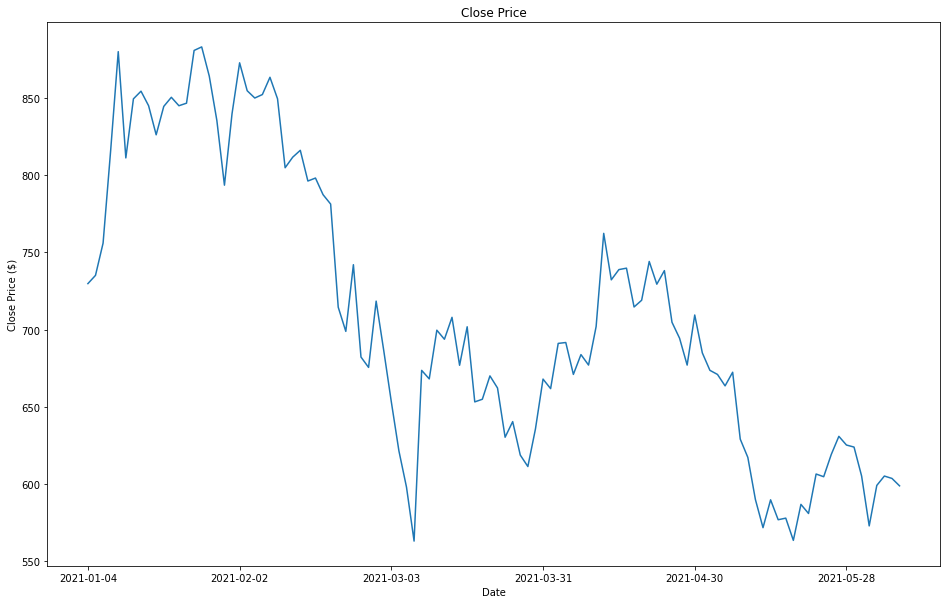

In [30]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close/Last'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [28]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-12,796.792857,0.991671,0.048143,0.830714,0.121143,787.948571,811.891414,775.720243,5.113753e+07
2021-01-13,814.598571,0.991900,0.046857,0.835571,0.117714,806.991429,828.460000,792.121743,4.894814e+07
2021-01-14,830.297143,0.991900,0.049143,0.831000,0.120000,824.095714,845.911429,809.200314,4.880831e+07
